All the information on how to use the Statmorph library can be found at https://statmorph.readthedocs.io/en/latest/

# Import

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
import photutils
import time
import statmorph
import scipy.ndimage as ndi
from astropy.convolution import convolve
from astropy.table import Table
from astropy.table import Column
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import SourceCatalog

## Paths

In [114]:
directory = './downloaded_data/'

## Open the image

In [115]:
fits_input = fits.open(directory+'ILTJ160029.87+550150.1.fits')
fits_input.info()
data=fits_input[1].data
hdr=fits_input[1].header

Filename: ./downloaded_data/ILTJ160029.87+550150.1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1                1 ImageHDU        31   (61, 61)   float32   
  2                1 ImageHDU        48   (61, 61)   int32   
  3                1 ImageHDU        31   (61, 61)   float32   


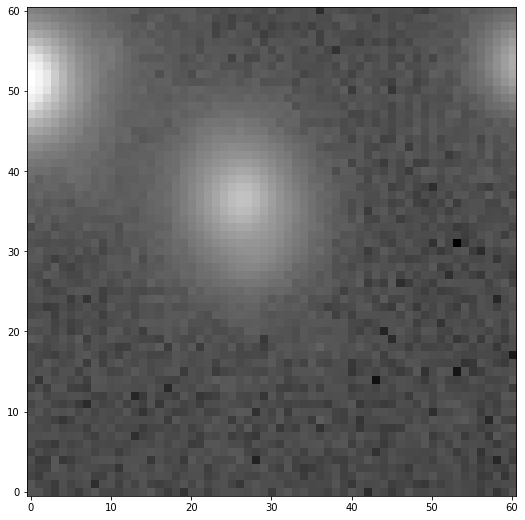

In [116]:
plt.figure(figsize=(9,9))

plt.imshow(data, cmap='gray', origin='lower',
           norm=simple_norm(data, stretch='log', log_a=10000))

plt.show()

In [117]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (25,25), filter_size=(3,3),
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

In [118]:
print(bkg.background_median) 

0.027494953150253156


In [119]:
print(bkg.background_rms_median)

0.06274050766428993


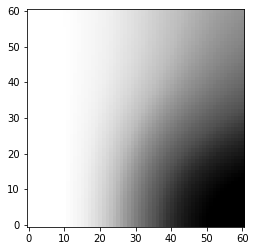

In [120]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',
           interpolation='nearest')

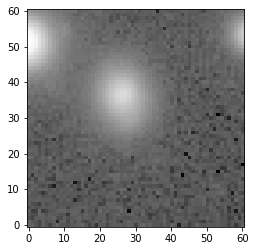

In [121]:
plt.imshow(data - bkg.background, norm=simple_norm(data, stretch='log', log_a=10000), origin='lower',
            cmap='Greys_r', interpolation='nearest')

In [122]:
gain = 3

## Generate a PSF

A use a simple Gaussian PSF with a FWHM of 0.77 arcsec (or 3.7 pixels)

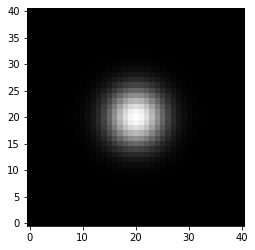

In [123]:
size = 20  # on each side from the center
sigma_psf = 3.7 #FWHM KiDS is 0.77 arcsec
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)

plt.imshow(psf, origin='lower', cmap='gray')
plt.show()

## No Need for convolving!

In [124]:
# data = convolve(data, psf)

# plt.figure(figsize=(9,9))

# plt.imshow(data, cmap='gray', origin='lower',
#            norm=simple_norm(data, stretch='log', log_a=10000))


# plt.show()

## Create a segmentation map

In [125]:
threshold = photutils.detect_threshold(data-bkg.background, 1.5)
npixels = 5
segm = photutils.detect_sources(data-bkg.background, threshold, npixels)

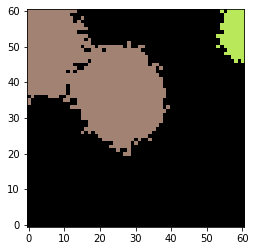

In [126]:
cmap = segm.make_cmap(seed=123)

plt.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
plt.show()

In [127]:
cat = SourceCatalog(data, segm)

tbl = cat.to_table()

tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,8.940425904519252,46.640038011047366,None,0,39,20,60,939.0,13.513356388643949,3.314870755960692,-32.02947794523308,0.9694463867728977,0.20365357398986816,134.98484802246094,0.0,2861.0949975699186,nan,2855.344577453468,nan
2,58.592134216414145,53.46901386027349,None,53,60,46,60,90.0,2.8346574871438373,1.5734975870345784,-87.72455500611608,0.8317885128310302,0.20648911595344543,6.453038215637207,0.0,106.84022602438927,nan,112.33374396489833,nan


In [128]:
x, y = tbl['xcentroid'], tbl['ycentroid']

new_tbl = tbl[(x<40.)&(x>20.) & (y>20.)&(y<40.)]
new_tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [129]:
index = np.argmax(new_tbl['area'])

print(new_tbl['label'][np.argmax(new_tbl['area'])])

ValueError: attempt to get argmax of an empty sequence

In [ ]:
# Keep only the largest segment
label = new_tbl['label'][index]
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

plt.show()

0.29000000000000004


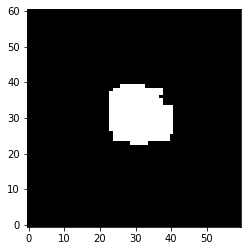

In [98]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
print(np.max(segmap_float))
segmap = segmap_float > 0.
plt.imshow(segmap, origin='lower', cmap='gray')

plt.show()

## Running Statmorph

In [77]:
segmap.astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [78]:
start = time.time()
source_morphs = statmorph.source_morphology(
    data-bkg.background, segmap.astype(int), gain=gain,psf=psf)
print('Time: %g s.' % (time.time() - start))

Time: 1.34968 s.


In [79]:
morph = source_morphs[0]

In [80]:
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

xc_centroid = 28.865463841854844
yc_centroid = 27.79839769774033
ellipticity_centroid = 0.21757204528274288
elongation_centroid = 1.2780729445708086
orientation_centroid = -0.3787033277513337
xc_asymmetry = 28.708035584702067
yc_asymmetry = 27.941185335752923
ellipticity_asymmetry = 0.21787402082312513
elongation_asymmetry = 1.2785664031418826
orientation_asymmetry = -0.3796659948860997
rpetro_circ = 26.049453151414717
rpetro_ellip = 27.68186853977192
rhalf_circ = 8.441991723303259
rhalf_ellip = 9.397071803511778
r20 = 3.1846123785200042
r50 = 8.455009836892897
r80 = 18.50986928134845
Gini = 0.5792228750937628
M20 = -2.2770158876977624
F(G, M20) = 0.48512524188867534
S(G, M20) = -0.07007456204716389
sn_per_pixel = 1.1693241404994745
C = 3.821733864328025
A = -0.10153512022579789
S = -0.0710917934986848
sersic_amplitude = 1.6775359344925738
sersic_rhalf = 9.397071803511778
sersic_n = 3.4507344705547762
sersic_xc = 28.708035584702067
sersic_yc = 27.941185335752923
sersic_ellip = 0.217874

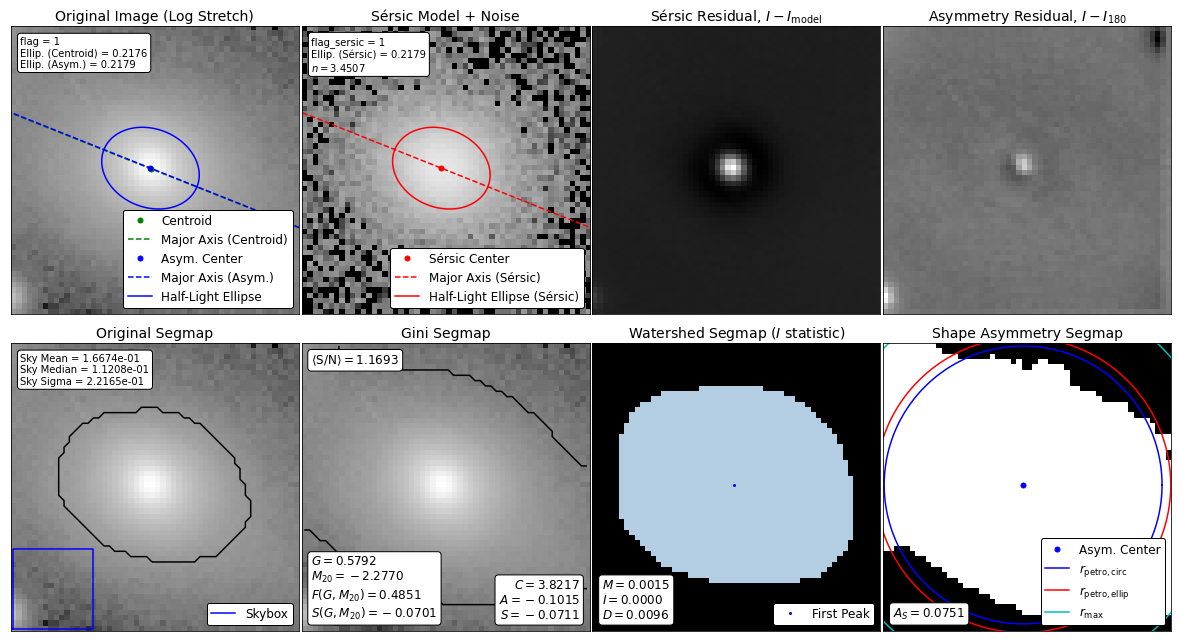

In [81]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

### Run Statmorph on a batch of images and save the parameters in a table

In [ ]:
for name in file_names:
    
    start = time.time()
    
    try:
        fits_input = fits.open(directory+name)
        fits_input.info()
        data=fits_input[0].data
        hdr=fits_input[0].header

        data = sub_background(data, show_plots=True)

    
        segmap = segmentation_map(data, show_plots=True)
        
#     except:
#         print('I skip this galaxy: ', name, '\n')
#         continue
    
#     try:
        source_morphs = statmorph.source_morphology(
            data, segmap, gain=gain,psf=psf)


        morph = source_morphs[0]
        new_row = [name, morph.xc_centroid, morph.yc_centroid, morph.ellipticity_centroid, morph.elongation_centroid,
               morph.orientation_centroid, morph.xc_asymmetry, morph.yc_asymmetry, morph.ellipticity_asymmetry, 
               morph.elongation_asymmetry, morph.orientation_asymmetry, morph.r20,morph.r50,morph.r80,
               morph.rhalf_circ, morph.rhalf_ellip, morph.rmax_circ, morph.rmax_ellip, morph.rpetro_circ,
               morph.rpetro_ellip, morph.concentration, morph.asymmetry, morph.smoothness, morph.m20, morph.gini,
               morph.gini_m20_bulge, morph.gini_m20_merger, morph.deviation, morph.shape_asymmetry, 
               morph.outer_asymmetry, morph.multimode, morph.sn_per_pixel, morph.flux_circ, morph.flux_ellip,
               morph.intensity, morph.sersic_xc, morph.sersic_yc, morph.sersic_amplitude, morph.sersic_ellip,
               morph.sersic_n, morph.sersic_rhalf, morph.sersic_theta, morph.sky_mean, morph.sky_median, 
               morph.sky_sigma, morph.nx_stamp, morph.ny_stamp, morph.xmax_stamp, morph.xmin_stamp,
               morph.ymax_stamp, morph.ymin_stamp, morph.flag, morph.flag_sersic
              ]

        table.add_row(new_row)
        
    except:
        print('I skip this galaxy: ',name,'\n')
        continue

    print('Time: %g s.' % (time.time() - start))

## Various

In [114]:
morph.asymmetry
morph.concentration
morph.deviation
morph.ellipticity_asymmetry
morph.ellipticity_centroid
morph.elongation_asymmetry
morph.elongation_centroid
morph.flux_circ
morph.flux_ellip
morph.gini
morph.gini_m20_bulge
morph.gini_m20_merger
morph.intensity
morph.m20
morph.multimode
morph.nx_stamp
morph.ny_stamp
morph.orientation_asymmetry
morph.orientation_centroid
morph.outer_asymmetry
morph.r20
morph.r50
morph.r80
morph.rhalf_circ
morph.rhalf_ellip
morph.rmax_circ
morph.rmax_ellip
morph.rpetro_circ
morph.rpetro_ellip
morph.sersic_amplitude
morph.sersic_ellip
morph.sersic_n
morph.sersic_rhalf
morph.sersic_theta
morph.sersic_xc
morph.sersic_yc
morph.shape_asymmetry
morph.sky_mean
morph.sky_median
morph.sky_sigma
morph.smoothness
morph.sn_per_pixel
morph.xc_asymmetry
morph.xc_centroid
morph.xmax_stamp
morph.xmin_stamp
morph.yc_asymmetry
morph.yc_centroid
morph.ymax_stamp
morph.ymin_stamp
morph.flag
morph.flag_sersic

0

In [156]:
col_names = ('ID','xc_centroid','yc_centroid', 'ellipticity_centroid', 'elongation_centroid', 'orientation_centroid',
         'xc_asymmetry', 'yc_asymmetry','ellipticity_asymmetry', 'elongation_asymmetry', 'orientation_asymmetry',
         'r20','r50','r80','rhalf_circ','rhalf_ellip','rmax_circ','rmax_ellip','rpetro_circ','rpetro_ellip',
         'C','A','S','M20','Gini', 'F(G,M20)', 'S(G,M20)', 'deviation', 'shape_asymmetry','outer_asymmetry',
         'multimode','sn_per_pixel','flux_circ','flux_ellip','intensity',
         'sersic_xc','sersic_yc','sersic_amplitude', 'sersic_ellip','sersic_n','sersic_rhalf','sersic_theta',
         'sky_mean','sky_median','sky_sigma',
         'nx_stamp','ny_stamp','xmax_stamp','xmin_stamp','ymax_stamp','ymin_stamp',
        'flag', 'flag_sersic'
        )

t = Table(names=col_names)
t['ID'] = Column(name='ID', dtype='str')

In [151]:
a = ['name_code', morph.xc_centroid,morph.yc_centroid,morph.deviation,
morph.ellipticity_asymmetry,
morph.ellipticity_centroid,
morph.elongation_asymmetry,
morph.elongation_centroid,
morph.flux_circ,
morph.flux_ellip,
morph.gini,
morph.gini_m20_bulge,
morph.gini_m20_merger,
morph.intensity,
morph.m20,
morph.multimode,
morph.nx_stamp,
morph.ny_stamp,
morph.orientation_asymmetry,
morph.orientation_centroid,
morph.outer_asymmetry,
morph.r20,
morph.r50,
morph.r80,
morph.rhalf_circ,
morph.rhalf_ellip,
morph.rmax_circ,
morph.rmax_ellip,
morph.rpetro_circ,
morph.rpetro_ellip,
morph.sersic_amplitude,
morph.sersic_ellip,
morph.sersic_n,
morph.sersic_rhalf,
morph.sersic_theta,
morph.sersic_xc,
morph.sersic_yc,
morph.shape_asymmetry,
morph.sky_mean,
morph.sky_median,
morph.sky_sigma,
morph.smoothness,
morph.sn_per_pixel,
morph.xc_asymmetry,
morph.xc_centroid,
morph.xmax_stamp,
morph.xmin_stamp,
morph.yc_asymmetry,
morph.yc_centroid,
morph.ymax_stamp,
morph.ymin_stamp,
morph.flag,
morph.flag_sersic
    ]

# a.append('name_code')

# a.append(morph.xc_centroid,morph.yc_centroid)

a

['name_code',
 157.3893317511049,
 121.30740903884127,
 0.32029018213477545,
 0.1551522591067741,
 0.19160695427797958,
 1.1836452316753991,
 1.2370220220126273,
 8666.128848703593,
 8666.128848703594,
 0.54317602576636,
 -0.21027314712434508,
 -0.0020692525593728472,
 0.7328667869206796,
 -1.5310325040868293,
 1.0,
 194,
 194,
 -0.4177011168256745,
 -0.6953135854787489,
 0.38249759950306866,
 22.131080130431307,
 42.41955241051065,
 80.0897508882391,
 42.055457867630196,
 44.48019568045921,
 125.57571534926569,
 128.42783250271876,
 107.3520195931731,
 114.14304095614362,
 0.05159898604980519,
 0.44220208305721925,
 1.4317296809509419,
 178.64349385085103,
 2.439791162379436,
 152.59608044563475,
 115.70192792942363,
 0.5066768961049111,
 0.08068444,
 0.08056289,
 0.027078442,
 -0.046394609113095765,
 0.63315296,
 147.23718668178114,
 157.3893317511049,
 238,
 45,
 117.78347771345625,
 121.30740903884127,
 224,
 31,
 1,
 0]

In [158]:
t.add_row(a)

In [159]:
t

ID,xc_centroid,yc_centroid,ellipticity_centroid,elongation_centroid,orientation_centroid,xc_asymmetry,yc_asymmetry,ellipticity_asymmetry,elongation_asymmetry,orientation_asymmetry,r20,r50,r80,rhalf_circ,rhalf_ellip,rmax_circ,rmax_ellip,rpetro_circ,rpetro_ellip,C,A,S,M20,Gini,"F(G,M20)","S(G,M20)",deviation,shape_asymmetry,outer_asymmetry,multimode,sn_per_pixel,flux_circ,flux_ellip,intensity,sersic_xc,sersic_yc,sersic_amplitude,sersic_ellip,sersic_n,sersic_rhalf,sersic_theta,sky_mean,sky_median,sky_sigma,nx_stamp,ny_stamp,xmax_stamp,xmin_stamp,ymax_stamp,ymin_stamp,flag,flag_sersic
str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
name_code,157.3893317511049,121.30740903884127,0.32029018213477545,0.1551522591067741,0.19160695427797958,1.1836452316753991,1.2370220220126273,8666.128848703593,8666.128848703594,0.54317602576636,-0.21027314712434508,-0.0020692525593728472,0.7328667869206796,-1.5310325040868293,1.0,194.0,194.0,-0.4177011168256745,-0.6953135854787489,0.38249759950306866,22.131080130431307,42.41955241051065,80.0897508882391,42.055457867630196,44.48019568045921,125.57571534926569,128.42783250271876,107.3520195931731,114.14304095614362,0.05159898604980519,0.44220208305721925,1.4317296809509419,178.64349385085103,2.439791162379436,152.59608044563475,115.70192792942363,0.5066768961049111,0.08068443834781647,0.08056288957595825,0.02707844227552414,-0.046394609113095765,0.633152961730957,147.23718668178114,157.3893317511049,238.0,45.0,117.78347771345625,121.30740903884127,224.0,31.0,1.0,0.0
